# ทดสอบรวมฝนรายชั่วโมงเป็นฝนรายวัน ใช้คอลัมน์ full_date และ code พลอต density ใช้ ZR SDC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import linregress
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


## read cleansing 

In [2]:
df = pd.read_csv('./00Results/00rain_radar_hourly_extracted_all_events/df_org_dbz_rain_test120km.csv')
#df = pd.read_csv('./00Results/00rain_radar_hourly_extracted_all_events/df_org_dbz_rain_test200km.csv')
df.drop(df[df['cappi4km'] < 10].index, inplace = True) #ฝนอ่่อนมากๆ < 10 dBZ
df.drop(df[df['cappi4km'] > 55].index, inplace = True) #ค่าการสะท้อนที่อาจเป็นลูกเห็บ 55 dBZ มุมยกด้านบนสุด
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df
#df.head()

,cappi1km,cappi2km,cappi3km,cappi4km,full_date,code,rain_x
0,28.491104,28.182693,27.482676,26.134428,2018-06-01-00:00,CMSG,0.0
1,18.245508,17.964867,17.979790,18.295288,2018-06-01-00:00,CTKN,10.8
2,27.273252,27.500923,27.998676,28.672308,2018-06-01-00:00,KGTP,0.0
3,27.172401,27.172401,27.172401,27.172401,2018-06-01-00:00,LPLE,0.0
4,29.211285,29.136589,24.834078,22.473293,2018-06-01-00:00,NAN008,0.0
...,...,...,...,...,...,...,...
15877,47.794342,47.810116,47.825912,47.841797,2018-09-21-23:00,PPTC,0.0
15878,21.874329,21.874329,21.874329,21.874329,2018-09-21-23:00,TBR013,0.0
15879,28.704351,28.712242,28.719904,29.000463,2018-09-21-23:00,TBW014,0.0
15880,10.786102,10.775164,10.764159,10.816386,2018-09-21-23:00,WTBT,0.0


### เปลี่ยนชื่อคอลัมน์

In [3]:
df.rename(columns={"cappi1km": "dBZ_c1", "cappi2km": "dBZ_c2","cappi3km": "dBZ_c3","cappi4km": "dBZ_c4"}, inplace=True)
df.rename(columns={"rain_x":"rain_truth"}, inplace=True)
df

,dBZ_c1,dBZ_c2,dBZ_c3,dBZ_c4,full_date,code,rain_truth
0,28.491104,28.182693,27.482676,26.134428,2018-06-01-00:00,CMSG,0.0
1,18.245508,17.964867,17.979790,18.295288,2018-06-01-00:00,CTKN,10.8
2,27.273252,27.500923,27.998676,28.672308,2018-06-01-00:00,KGTP,0.0
3,27.172401,27.172401,27.172401,27.172401,2018-06-01-00:00,LPLE,0.0
4,29.211285,29.136589,24.834078,22.473293,2018-06-01-00:00,NAN008,0.0
...,...,...,...,...,...,...,...
15877,47.794342,47.810116,47.825912,47.841797,2018-09-21-23:00,PPTC,0.0
15878,21.874329,21.874329,21.874329,21.874329,2018-09-21-23:00,TBR013,0.0
15879,28.704351,28.712242,28.719904,29.000463,2018-09-21-23:00,TBW014,0.0
15880,10.786102,10.775164,10.764159,10.816386,2018-09-21-23:00,WTBT,0.0


### คำนวน rain estimates จาก ZRs

In [4]:
### ZR Summer Deep Convection
a=300. 
b=1.4
df['rr_SC_c1']=((10**(df['dBZ_c1']/10.))/a)**(1/b)
df['rr_SC_c2']=((10**(df['dBZ_c2']/10.))/a)**(1/b)
df['rr_SC_c3']=((10**(df['dBZ_c3']/10.))/a)**(1/b)
df['rr_SC_c4']=((10**(df['dBZ_c4']/10.))/a)**(1/b)
df

,dBZ_c1,dBZ_c2,dBZ_c3,dBZ_c4,full_date,code,rain_truth,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4
0,28.491104,28.182693,27.482676,26.134428,2018-06-01-00:00,CMSG,0.0,1.843769,1.752577,1.561982,1.251332
1,18.245508,17.964867,17.979790,18.295288,2018-06-01-00:00,CTKN,10.8,0.341884,0.326462,0.327264,0.344694
2,27.273252,27.500923,27.998676,28.672308,2018-06-01-00:00,KGTP,0.0,1.509097,1.566677,1.700330,1.899545
3,27.172401,27.172401,27.172401,27.172401,2018-06-01-00:00,LPLE,0.0,1.484272,1.484272,1.484272,1.484272
4,29.211285,29.136589,24.834078,22.473293,2018-06-01-00:00,NAN008,0.0,2.075621,2.050277,1.010393,0.685272
...,...,...,...,...,...,...,...,...,...,...,...
15877,47.794342,47.810116,47.825912,47.841797,2018-09-21-23:00,PPTC,0.0,44.107176,44.221752,44.336793,44.452775
15878,21.874329,21.874329,21.874329,21.874329,2018-09-21-23:00,TBR013,0.0,0.620983,0.620983,0.620983,0.620983
15879,28.704351,28.712242,28.719904,29.000463,2018-09-21-23:00,TBW014,0.0,1.909583,1.912063,1.914474,2.004884
15880,10.786102,10.775164,10.764159,10.816386,2018-09-21-23:00,WTBT,0.0,0.100245,0.100065,0.099884,0.100746


In [5]:
## ดรอปคอมลัมน์ cappi ทิ้ง
df.drop(columns=['dBZ_c1','dBZ_c2','dBZ_c3','dBZ_c4'], inplace=True) #ลบคอลัน์
df

,full_date,code,rain_truth,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4
0,2018-06-01-00:00,CMSG,0.0,1.843769,1.752577,1.561982,1.251332
1,2018-06-01-00:00,CTKN,10.8,0.341884,0.326462,0.327264,0.344694
2,2018-06-01-00:00,KGTP,0.0,1.509097,1.566677,1.700330,1.899545
3,2018-06-01-00:00,LPLE,0.0,1.484272,1.484272,1.484272,1.484272
4,2018-06-01-00:00,NAN008,0.0,2.075621,2.050277,1.010393,0.685272
...,...,...,...,...,...,...,...
15877,2018-09-21-23:00,PPTC,0.0,44.107176,44.221752,44.336793,44.452775
15878,2018-09-21-23:00,TBR013,0.0,0.620983,0.620983,0.620983,0.620983
15879,2018-09-21-23:00,TBW014,0.0,1.909583,1.912063,1.914474,2.004884
15880,2018-09-21-23:00,WTBT,0.0,0.100245,0.100065,0.099884,0.100746


### รวมฝนรายชั่วโมงเป็นรายวัน ด้วยการสร้างคอลัมน์ date_only เพือ่ใช้ร่วมกับคอลัมน์ code

In [6]:
# Extract date from 'full_date' column
df['date_only'] = pd.to_datetime(df['full_date']).dt.date

# Group by 'date_only' and 'code', then sum the 'rain_truth' values
aggregated_data = df.groupby(['date_only', 'code']).sum().reset_index()

# replace NaN with 0 after aggregation using fillna(0)
#aggregated_data.fillna(0, inplace=True)

aggregated_data.dropna(inplace=True)
aggregated_data.reset_index(drop=True)

# The resulting DataFrame 'aggregated_data' will have the aggregated values
print(aggregated_data)

       date_only    code  rain_truth   rr_SC_c1   rr_SC_c2   rr_SC_c3  \
0     2018-06-01    BPPS         0.2   1.716766   1.841046   2.140117   
1     2018-06-01    BRKM         0.0   0.910027   0.926918   0.868426   
2     2018-06-01    BWKG         0.0   2.657116   2.708626   2.881853   
3     2018-06-01    CMSG         4.8  21.954865  21.431417  20.840512   
4     2018-06-01    CNDN         0.0  22.600377  22.573976  19.160159   
...          ...     ...         ...        ...        ...        ...   
2538  2018-09-21    WTBT         0.0   0.519193   0.519014   0.518839   
2539  2018-09-21    WTLG         0.0   2.999392   3.004958   3.091494   
2540  2018-09-21  YOM007         0.0   0.400338   0.384449   0.367391   
2541  2018-09-21  YOM008         0.0   0.250275   0.228563   0.237574   
2542  2018-09-21  YOM009         0.0  78.819804  78.742212  78.799263   

       rr_SC_c4  
0      2.405615  
1      0.860466  
2      2.411153  
3     18.709725  
4      3.777791  
...         ...

In [7]:
# conditional rain
df_=aggregated_data[aggregated_data['rain_truth']>0]
df_=df_[df_['rr_SC_c1']>0]

In [8]:
df_.reset_index(drop=True, inplace=True)

In [9]:
df_.describe()

,rain_truth,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4
count,1227.000000,1227.000000,1227.000000,1227.000000,1227.000000
mean,6.041728,26.133798,25.483899,24.590591,23.080241
std,9.312912,33.562202,31.740719,30.195358,28.204408
min,0.200000,0.156654,0.156654,0.152694,0.122128
25%,0.600000,6.248620,6.558034,6.575365,6.183616
50%,2.000000,13.417577,14.114142,14.317393,13.270842
75%,7.400000,32.055762,32.129860,31.817498,29.020798
max,77.800000,309.774029,290.594113,292.815522,304.763985


In [10]:
df_.corr()

,rain_truth,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4
rain_truth,1.000000,0.519209,0.530567,0.525361,0.522586
rr_SC_c1,0.519209,1.000000,0.951842,0.915093,0.849274
rr_SC_c2,0.530567,0.951842,1.000000,0.963009,0.896859
rr_SC_c3,0.525361,0.915093,0.963009,1.000000,0.918354
rr_SC_c4,0.522586,0.849274,0.896859,0.918354,1.000000


## พลอต scatter คำนวณสถิติ และ พลอตค่า metrics

In [11]:
def density_plot(rain_truth, rain_radar):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde
    from scipy.stats import linregress
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    # data
    x = rain_radar
    y = rain_truth

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    # Set the desired colorbar range
    cbar_min = 0  # specify your minimum value
    cbar_max = 0.002  # specify your maximum value

    # Create scatter plot with density color map
    fig, ax = plt.subplots()
    scatter = ax.scatter(x, y, c=z, s=20, cmap='jet', alpha=0.8, vmin=cbar_min, vmax=cbar_max)

    
    max_ = 50
    # Set x and y axis limits
    plt.xlim(0, max_)
    plt.ylim(0, max_)

    # Plot the 1:1 line
    plt.plot([0, max_], [0, max_], linestyle='-', color='black', linewidth=2)

    plt.xlabel('rain_truth [mm/hr]')
    plt.ylabel('rain_radar [mm/hr]')

    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Density')

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(x, y))
    mse = mean_squared_error(x, y)
    mae = mean_absolute_error(x, y)
    r2 = r2_score(x, y)

    # Calculate p-value and correlation coefficient (r)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Print results
    print(f'RMSE: {rmse}')
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'R-squared: {r2}')
    print(f'Correlation coefficient (r): {r_value}')
    print(f'P-value: {p_value}')

    # Plot the regression line
    plt.plot(x, slope * x + intercept, linestyle='-', color='magenta', linewidth=2,
             label=f'Regression Line (r={r_value:.2f}, p={p_value:.4f})')
    plt.xlabel('rain_radar [mm/day]')
    plt.ylabel('rain_truth [mm/day]')
    plt.title('Daily rain_radar and rain_truth [mm/day]')
    plt.legend()

    # Display the plot
    plt.show()


RMSE: 35.93812839943474
MSE: 1291.549072854258
MAE: 20.805494375688916
R-squared: -0.14753015643871437
Correlation coefficient (r): 0.519208864048863
P-value: 1.20371723829763e-85


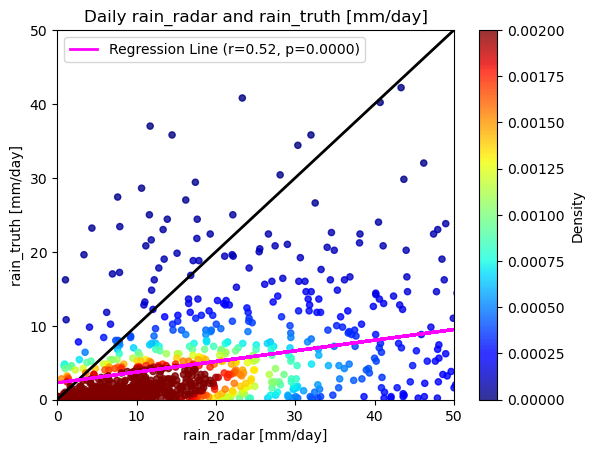

In [12]:
density_plot(df_['rain_truth'],df_['rr_SC_c1'])

RMSE: 34.02787250077668
MSE: 1157.896106929114
MAE: 19.981554639088596
R-squared: -0.15024447104502525
Correlation coefficient (r): 0.5305665741935915
P-value: 4.934163052643942e-90


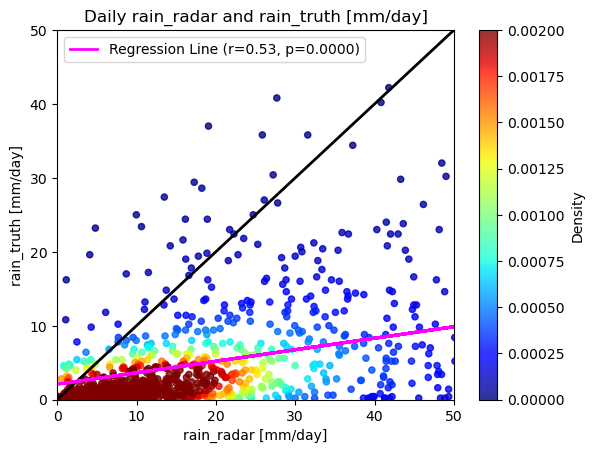

In [13]:
density_plot(df_['rain_truth'],df_['rr_SC_c2'])

RMSE: 32.34976071593745
MSE: 1046.5070183784098
MAE: 18.98957361507561
R-squared: -0.1487244825298153
Correlation coefficient (r): 0.5253614173739565
P-value: 5.303669220664173e-88


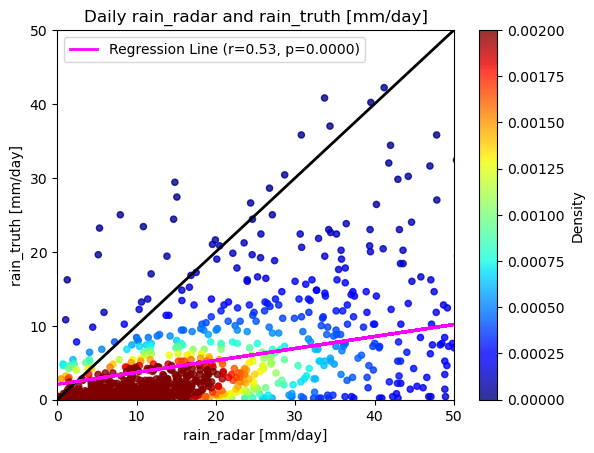

In [14]:
density_plot(df_['rain_truth'],df_['rr_SC_c3'])

RMSE: 29.95837656379298
MSE: 897.5043263380205
MAE: 17.530054226411544
R-squared: -0.1291630623734179
Correlation coefficient (r): 0.5225860830932885
P-value: 6.213102706420212e-87


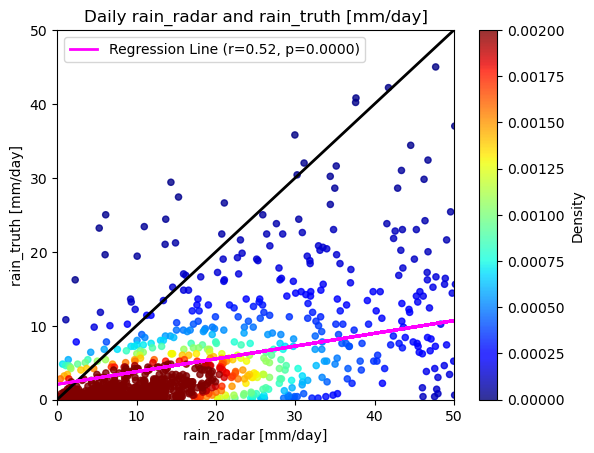

In [15]:
density_plot(df_['rain_truth'],df_['rr_SC_c4'])

### คำนวณสถิติ และ พลอตค่า metrics

In [16]:
def density_plot_joint(rain_truth,rain_radar):
    # data
    x = rain_radar
    y = rain_truth

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(x, y))
    mse = mean_squared_error(x, y)
    mae = mean_absolute_error(x, y)
    r2 = r2_score(x, y)

    # Calculate p-value and correlation coefficient (r)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Print results
    print(f'RMSE: {rmse}')
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'R-squared: {r2}')
    print(f'Correlation coefficient (r): {r_value}')
    print(f'P-value: {p_value}')

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    # Set the desired colorbar range
    cbar_min = 0  # specify your minimum value
    cbar_max = 0.002  # specify your maximum value

    # Create a joint plot with scatter plot, regression line, and density plot
    sns.set(style="whitegrid")
    g = sns.jointplot(x=x, y=y, kind="reg", height=7)
    plt.plot(x, slope * x + intercept, linestyle='-', color='magenta', linewidth=2,
             label=f'Regression Line (r={r_value:.2f}, p={p_value:.4f})')
    #plt.text(0.5, 0.9, f'r = {r_value:.2f}, p = {p_value:.4f}', horizontalalignment='center', verticalalignment='center', transform=g.ax_joint.transAxes)

    # Add scatter plot with density color map
    scatter = plt.scatter(x, y, c=z, s=20, cmap='jet', alpha=0.8, vmin=cbar_min, vmax=cbar_max)
    
    # Set scatter plot aspect ratio to be equal
    #plt.gca().set_aspect('equal', adjustable='box')
    
    max_=50

    # Set x and y axis limits
    plt.xlim(0, max_)
    plt.ylim(0, max_)

    # Plot the 1:1 line
    plt.plot([0, max_], [0, max_], linestyle='-', color='black', linewidth=2)

    plt.xlabel('rain_radar [mm/day]')
    plt.ylabel('rain_truth [mm/day]')
    plt.title('Daily rain_radar and rain_truth [mm/day]')

    # Add colorbar using the scatter variable
    cbar = plt.colorbar(scatter)
    cbar.set_label('Density')

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Display the plot
    plt.show()


RMSE: 35.93812839943474
MSE: 1291.549072854258
MAE: 20.805494375688916
R-squared: -0.14753015643871437
Correlation coefficient (r): 0.5192088640488639
P-value: 1.2037172382966693e-85


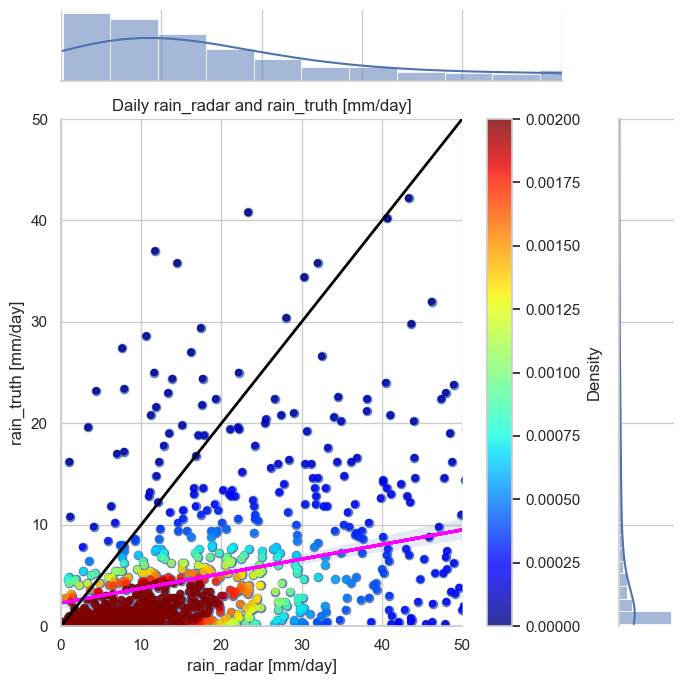

In [17]:
density_plot_joint(df_['rain_truth'],df_['rr_SC_c1'])

RMSE: 34.02787250077668
MSE: 1157.896106929114
MAE: 19.981554639088596
R-squared: -0.15024447104502525
Correlation coefficient (r): 0.530566574193591
P-value: 4.934163052646193e-90


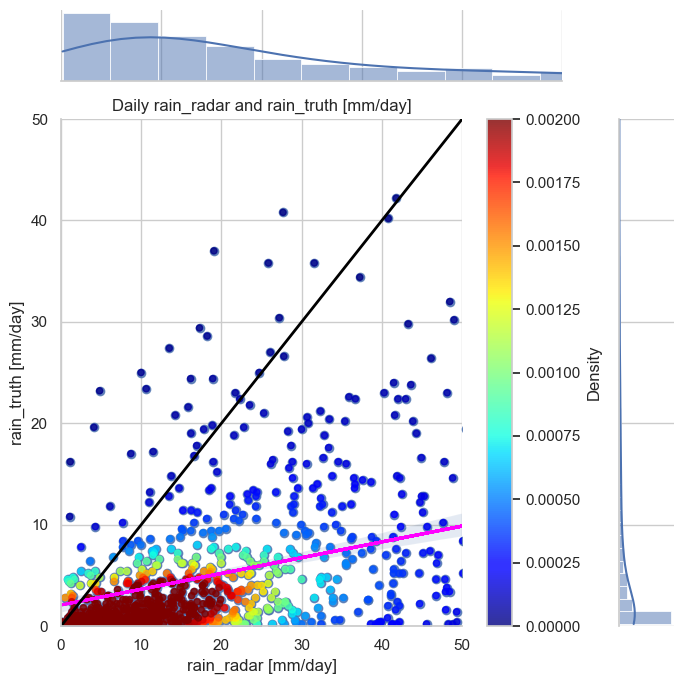

In [18]:
density_plot_joint(df_['rain_truth'],df_['rr_SC_c2'])

RMSE: 32.34976071593745
MSE: 1046.50701837841
MAE: 18.98957361507561
R-squared: -0.14872448252981552
Correlation coefficient (r): 0.5253614173739556
P-value: 5.303669220668706e-88


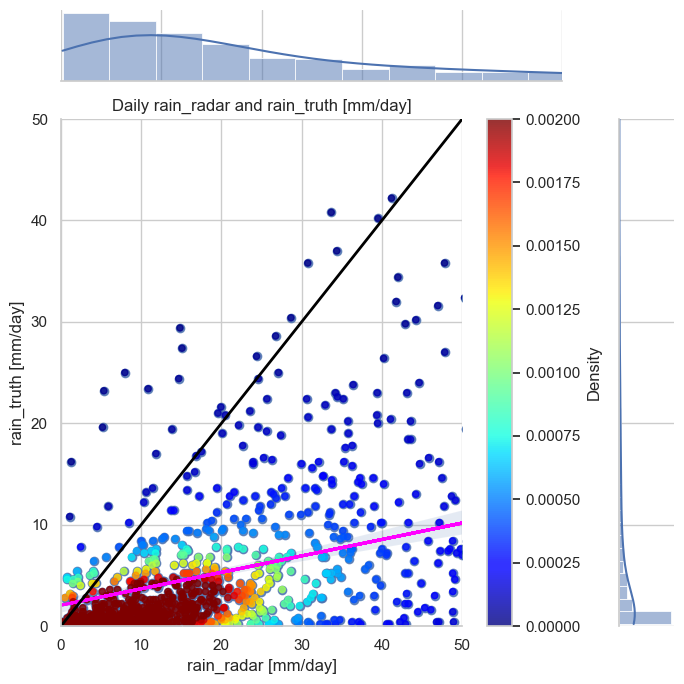

In [19]:
density_plot_joint(df_['rain_truth'],df_['rr_SC_c3'])

RMSE: 29.95837656379298
MSE: 897.5043263380205
MAE: 17.53005422641154
R-squared: -0.1291630623734179
Correlation coefficient (r): 0.5225860830932884
P-value: 6.213102706421097e-87


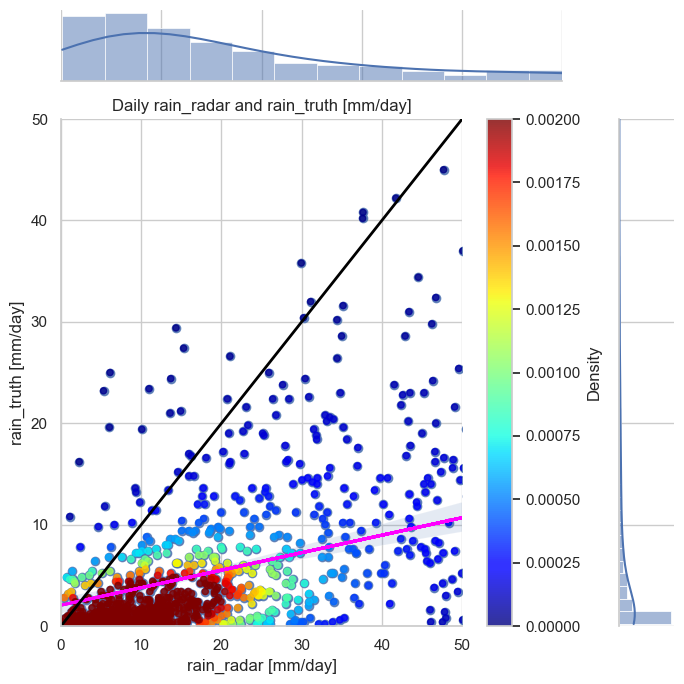

In [20]:
density_plot_joint(df_['rain_truth'],df_['rr_SC_c4'])

## รวมฝนรายวันเป็นฝนทั้งเหตุการณ์ของแต่ละสถานี

In [21]:
def density_plot_joint_events(rain_truth,rain_radar):
    # data
    x = rain_radar
    y = rain_truth

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(x, y))
    mse = mean_squared_error(x, y)
    mae = mean_absolute_error(x, y)
    r2 = r2_score(x, y)

    # Calculate p-value and correlation coefficient (r)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Print results
    print(f'RMSE: {rmse}')
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'R-squared: {r2}')
    print(f'Correlation coefficient (r): {r_value}')
    print(f'P-value: {p_value}')

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    # Set the desired colorbar range
    cbar_min = 0  # specify your minimum value
    cbar_max = 0.002  # specify your maximum value

    # Create a joint plot with scatter plot, regression line, and density plot
    sns.set(style="whitegrid")
    g = sns.jointplot(x=x, y=y, kind="reg", height=7)
    plt.plot(x, slope * x + intercept, linestyle='-', color='magenta', linewidth=2,
             label=f'Regression Line (r={r_value:.2f}, p={p_value:.4f})')
    #plt.text(0.5, 0.9, f'r = {r_value:.2f}, p = {p_value:.4f}', horizontalalignment='center', verticalalignment='center', transform=g.ax_joint.transAxes)

    # Add scatter plot with density color map
    scatter = plt.scatter(x, y, c=z, s=10, cmap='jet', alpha=0.8, vmin=cbar_min, vmax=cbar_max)
    
    # Set scatter plot aspect ratio to be equal
    #plt.gca().set_aspect('equal', adjustable='box')

    # Set x and y axis limits
    max_=50
    plt.xlim(0, max_)
    plt.ylim(0, max_)

    # Plot the 1:1 line
    plt.plot([0, max_], [0, max_], linestyle='-', color='black', linewidth=2)

    plt.xlabel('rain_radar [mm]')
    plt.ylabel('rain_truth [mm]')
    plt.title('Events rain_radar and rain_truth [mm]')

    # Add colorbar using the scatter variable
    cbar = plt.colorbar(scatter)
    cbar.set_label('Density')

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Display the plot
    plt.show()

In [22]:
df_

,date_only,code,rain_truth,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4
0,2018-06-01,BPPS,0.2,1.716766,1.841046,2.140117,2.405615
1,2018-06-01,CMSG,4.8,21.954865,21.431417,20.840512,18.709725
2,2018-06-01,CTKN,10.8,1.129375,1.078026,1.077120,1.093770
3,2018-06-01,KGKG,0.4,8.396274,9.160141,9.776408,8.714314
4,2018-06-01,KGLN,0.2,30.315838,29.984897,27.091772,5.854920
...,...,...,...,...,...,...,...
1222,2018-09-20,WTLG,0.2,4.528695,4.406049,4.275248,1.534193
1223,2018-09-21,CNDN,0.2,2.176009,2.405063,2.192781,1.899606
1224,2018-09-21,NAN013,24.8,117.966232,118.492239,119.853267,126.412131
1225,2018-09-21,PIN003,2.4,29.505538,28.007232,23.549834,16.527068


In [23]:
import pandas as pd

# Assuming df_ is your DataFrame
# Group by 'code' and calculate the mean for each group
aggregated_df = df_.groupby('code').mean().reset_index()

# Display the aggregated DataFrame
print("Aggregated DataFrame:")
df_=aggregated_df
print(df_)


Aggregated DataFrame:
      code  rain_truth   rr_SC_c1   rr_SC_c2   rr_SC_c3   rr_SC_c4
0     BDLH    5.726316  18.377951  16.080508  14.584052  14.105243
1     BMNK    0.200000   3.593696   3.877316   4.219240   4.428449
2     BPPS    5.341176  25.618133  22.343428  17.906021  14.989410
3     BRKM    3.333333  16.505044  16.478571  16.282129  14.376220
4     BWKG    5.162500  13.542803  13.469681  13.534700  13.672078
..     ...         ...        ...        ...        ...        ...
81  YOM006    4.892308  17.433651  16.671492  15.919512  14.828471
82  YOM007    3.800000  17.172701  19.718443  25.581618  46.523301
83  YOM008    4.781818  14.767530  14.899950  14.990212  16.502935
84  YOM009    7.600000  31.519059  38.920787  37.841705  34.963223
85  YOM012    0.342857  25.030202  25.424212  25.174599  24.473969

[86 rows x 6 columns]


In [24]:
df_.corr()

,rain_truth,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4
rain_truth,1.000000,0.490694,0.504384,0.496167,0.473785
rr_SC_c1,0.490694,1.000000,0.987579,0.955649,0.898341
rr_SC_c2,0.504384,0.987579,1.000000,0.985965,0.936797
rr_SC_c3,0.496167,0.955649,0.985965,1.000000,0.969669
rr_SC_c4,0.473785,0.898341,0.936797,0.969669,1.000000


RMSE: 26.559660436427063
MSE: 705.415562498309
MAE: 21.028683115097106
R-squared: -1.3041978571519457
Correlation coefficient (r): 0.49069361775969006
P-value: 1.6159623365932932e-06


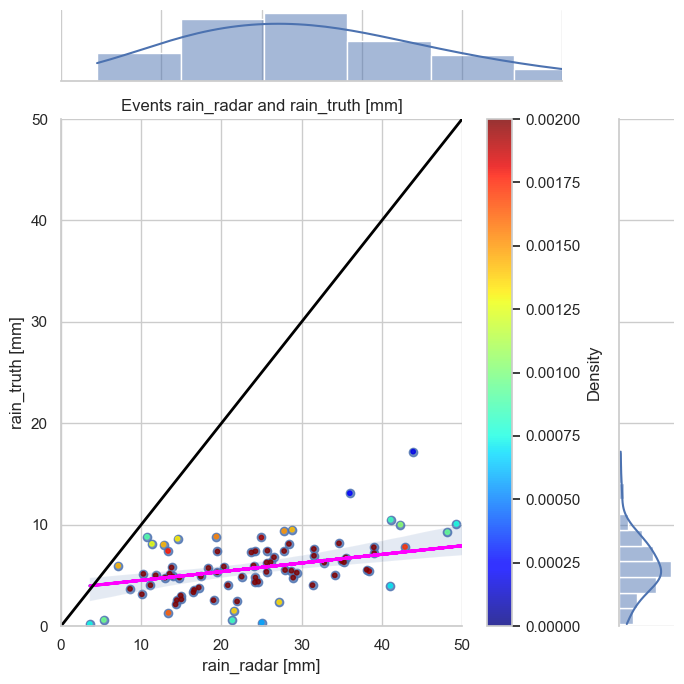

In [25]:
density_plot_joint_events(df_['rain_truth'],df_['rr_SC_c1'])

RMSE: 25.94018193634867
MSE: 672.8930388908698
MAE: 20.54578405369784
R-squared: -1.288080388219738
Correlation coefficient (r): 0.5043840906343576
P-value: 7.365096873507319e-07


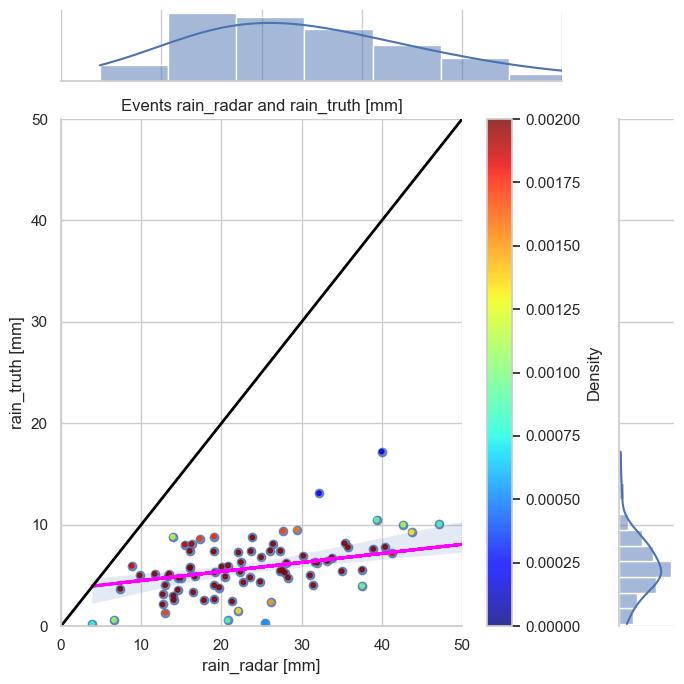

In [26]:
density_plot_joint_events(df_['rain_truth'],df_['rr_SC_c2'])

RMSE: 25.589301957911854
MSE: 654.8123746931914
MAE: 19.807346273735366
R-squared: -1.1400288465240576
Correlation coefficient (r): 0.4961666828786984
P-value: 1.1851732217992207e-06


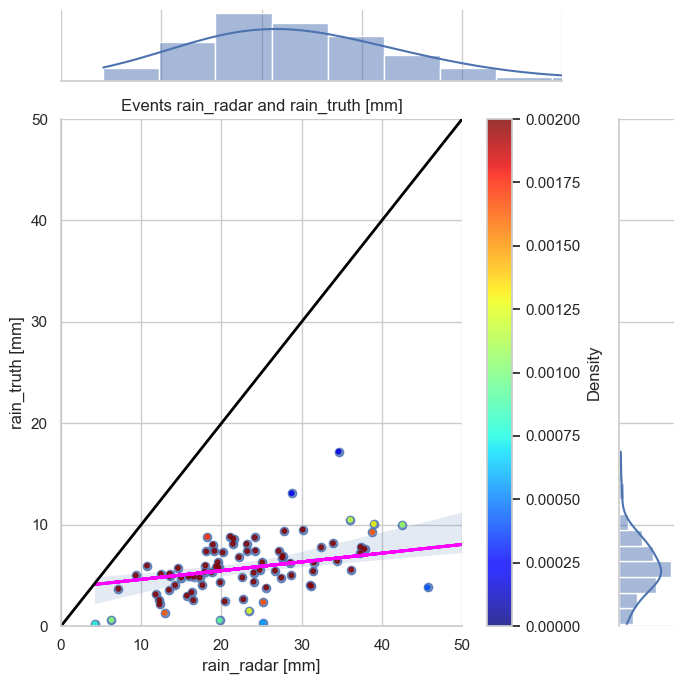

In [27]:
density_plot_joint_events(df_['rain_truth'],df_['rr_SC_c3'])

RMSE: 23.78374718778025
MSE: 565.6666302922449
MAE: 18.39265645796522
R-squared: -1.1345315826474374
Correlation coefficient (r): 0.4737854210543415
P-value: 4.073868607604108e-06


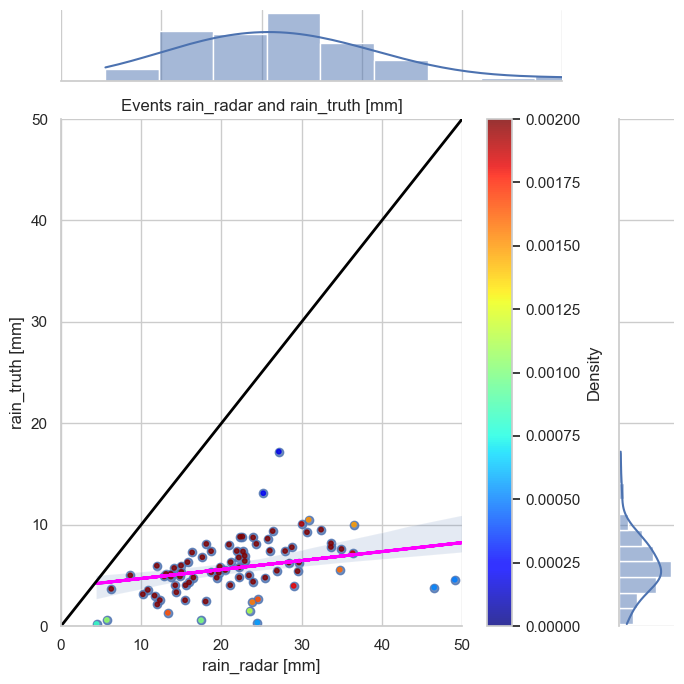

In [28]:
density_plot_joint_events(df_['rain_truth'],df_['rr_SC_c4'])

## หา bias และปรับแก้แบบ MFB Mean Field Bias Correction

In [45]:
MFB=df_['rr_SC_c1'].mean()/df_['rain_truth'].mean()
MFB     
#ต้องนำ MFB ไปปรับแก้ค่าฝน validate / testing

4.527700399796953

In [46]:
# ทดสอบปรับแก้ MFB ด้วยการคูณเข้ากับฝนประมาณค่าจากเรดาร์
df_['corrected_rr_SC_c1']=df_['rr_SC_c1']*(1/MFB)

In [47]:
df_.head()

,code,rain_truth,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4,corrected_rr_SC_c1
0,BDLH,5.726316,18.377951,16.080508,14.584052,14.105243,4.059003
1,BMNK,0.200000,3.593696,3.877316,4.219240,4.428449,0.793713
2,BPPS,5.341176,25.618133,22.343428,17.906021,14.989410,5.658089
3,BRKM,3.333333,16.505044,16.478571,16.282129,14.376220,3.645348
4,BWKG,5.162500,13.542803,13.469681,13.534700,13.672078,2.991100


In [48]:
df_.corr()

,rain_truth,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4,corrected_rr_SC_c1
rain_truth,1.000000,0.490694,0.504384,0.496167,0.473785,0.490694
rr_SC_c1,0.490694,1.000000,0.987579,0.955649,0.898341,1.000000
rr_SC_c2,0.504384,0.987579,1.000000,0.985965,0.936797,0.987579
rr_SC_c3,0.496167,0.955649,0.985965,1.000000,0.969669,0.955649
rr_SC_c4,0.473785,0.898341,0.936797,0.969669,1.000000,0.898341
corrected_rr_SC_c1,0.490694,1.000000,0.987579,0.955649,0.898341,1.000000


RMSE: 26.559660436427063
MSE: 705.415562498309
MAE: 21.028683115097106
R-squared: -1.3041978571519457
Correlation coefficient (r): 0.49069361775969006
P-value: 1.6159623365932932e-06


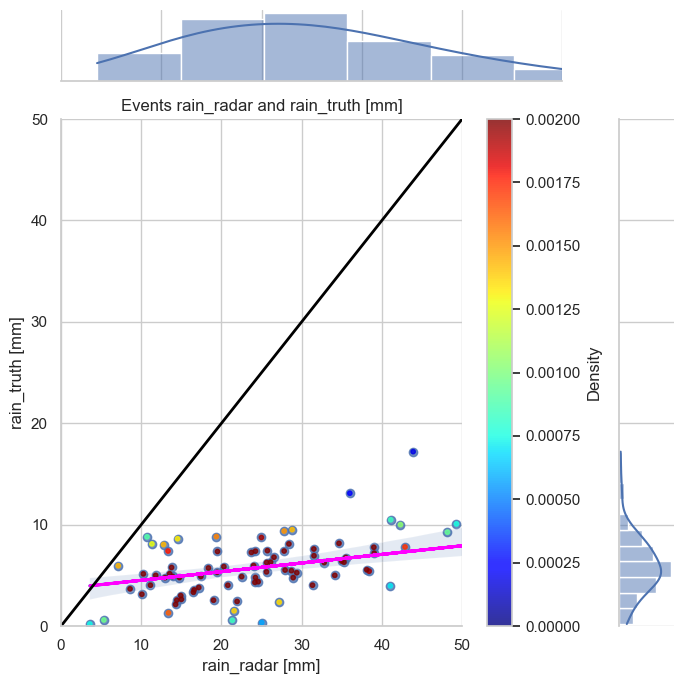

In [50]:
# ก่อนปรับแก้ MFB
density_plot_joint_events(df_['rain_truth'],df_['rr_SC_c1'])

RMSE: 3.5554090334116903
MSE: 12.64093339486545
MAE: 2.4304186240939294
R-squared: 0.15353454644150055
Correlation coefficient (r): 0.4906936177596903
P-value: 1.6159623365932685e-06


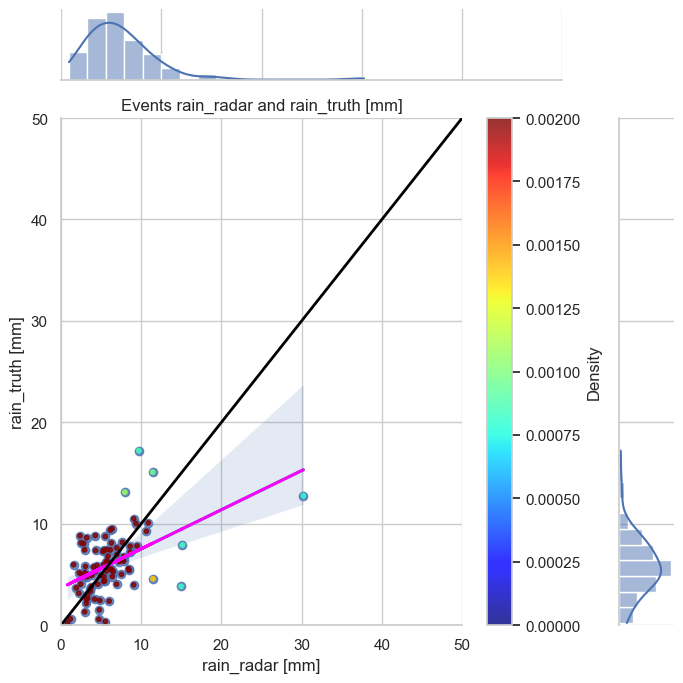

In [51]:
# หลังปรับแก้ MFB
density_plot_joint_events(df_['rain_truth'],df_['corrected_rr_SC_c1'])